<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
!pip install imageio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LeakyReLU, Flatten, Reshape, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time
import os
import tensorflow_datasets as tfds

In [97]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [98]:
#@title CONFIG

IMAGE_SIZE = 28
IMAGE_CHANNELS = 1
LATENT_DIM = 100
EPOCHS = 10
BATCH_SIZE = 64
SAMPLE_INTERVAL = 1
DATASET_SIZE = 60000
SAMPLES_DIR = 'images'

In [99]:
def preprocess_image(img):
  img = tf.cast(img['image'], tf.float32) / 127.5 - 1.
  img = tf.expand_dims(img, axis=3)
  return img

ds = tfds.load('mnist', split='train', shuffle_files=True, try_gcs=True)
dataset = ds.map(preprocess_image)
dataset = dataset.shuffle(DATASET_SIZE)
dataset = dataset.repeat()
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

per_replica_batch_size = BATCH_SIZE // strategy.num_replicas_in_sync

dataset = strategy.experimental_distribute_dataset(dataset)

In [100]:
class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
    noise_shape = (LATENT_DIM,)

    self.dense_1 = Dense(256, input_shape=noise_shape);
    self.lrelu_1 = LeakyReLU(alpha=0.2);
    self.bn_1 = BatchNormalization(momentum=0.8)

    self.dense_2 = Dense(512);
    self.lrelu_2 = LeakyReLU(alpha=0.2);
    self.bn_2 = BatchNormalization(momentum=0.8)

    self.dense_3 = Dense(1024);
    self.lrelu_3 = LeakyReLU(alpha=0.2);
    self.bn_3 = BatchNormalization(momentum=0.8)

    self.dense_4 = Dense(IMAGE_SIZE * IMAGE_SIZE * IMAGE_CHANNELS, activation='tanh');
    self.reshape = Reshape((IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))

  @tf.function
  def call(self, z, training=False):    
    x = self.dense_1(z)
    x = self.lrelu_1(x)
    x = self.bn_1(x)

    x = self.dense_2(x)
    x = self.lrelu_2(x)
    x = self.bn_2(x);

    x = self.dense_3(x)
    x = self.lrelu_3(x)
    x = self.bn_3(x);

    x = self.dense_4(x)
    x = self.reshape(x)
    
    return x

In [101]:
class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    img_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)

    self.flatten = Flatten(input_shape=img_shape)
    self.dense_1 = Dense(512)
    self.lrelu_1 = LeakyReLU(alpha=0.2)
    self.dense_2 = Dense(256)
    self.lrelu_2 = LeakyReLU(alpha=0.2)
    self.dense_3 = Dense(1, activation='sigmoid')
  
  @tf.function
  def call(self, z, training=False):    
    x = self.flatten(z)
    x = self.dense_1(x)
    x = self.lrelu_1(x)
    x = self.dense_2(x)
    x = self.lrelu_2(x)
    x = self.dense_3(x)

    return x

In [102]:
with strategy.scope():
  generator = Generator()
  discriminator = Discriminator()

In [103]:
with strategy.scope():
  generator_optimizer = Adam(0.0002, 0.5)
  discriminator_optimizer = Adam(0.0002, 0.5)

In [104]:
with strategy.scope():
  cross_entropy = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

def discriminator_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor :
  real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
  fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
  total_loss = real_loss + fake_loss

  return tf.nn.compute_average_loss(total_loss, global_batch_size=BATCH_SIZE)

def generator_loss(logits_fake: tf.Tensor) -> tf.Tensor:
  loss = cross_entropy(tf.ones_like(logits_fake), logits_fake)
  return tf.nn.compute_average_loss(loss, global_batch_size=BATCH_SIZE)

In [105]:
rows = 5
cols = 5

noise = np.random.normal(0, 1, (rows * cols, LATENT_DIM))

def sample_images(epoch=0, save=False, show=True):
  gen_imgs = generator(noise)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(
      wspace = 0.0,
      hspace = 0.0
  )
  px = 1/plt.rcParams['figure.dpi']

  fig.set_figheight(IMAGE_SIZE * rows * px)
  fig.set_figwidth(IMAGE_SIZE * cols * px)

  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * cols + i, :,:,0], cmap='gray')
  
      axs[i,j].axis('off')

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(SAMPLES_DIR, exist_ok=True)

  if save:
    plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
    
  if show:
    plt.show()
  else:
    plt.close(fig)

In [106]:
steps_per_epoch = DATASET_SIZE // BATCH_SIZE

@tf.function
def train_step(iterator):

  def step_fn(images):
    noise = tf.random.normal([per_replica_batch_size, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      gen_predictions = discriminator(generated_images, training=True)
      real_predictions = discriminator(images, training=True)
      
      disc_loss = discriminator_loss(real_predictions, gen_predictions)
      gen_loss = generator_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
    
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_weights)
    )

    return disc_loss, gen_loss


  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, gen_loss, axis=None) 

  return disc_loss, gen_loss

Number of devices: 8
Epoch: 1/10


Current step 937: 100%|██████████| 937/937 [00:37<00:00, 24.77it/s, disc_loss=1.39, gen_loss=0.69]


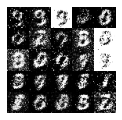

Time for epoch 1 is 39.17352271080017 sec
Epoch: 2/10


Current step 1874: 100%|██████████| 937/937 [00:21<00:00, 43.67it/s, disc_loss=1.39, gen_loss=0.693]


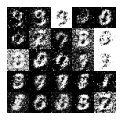

Time for epoch 2 is 22.297756910324097 sec
Epoch: 3/10


Current step 2811: 100%|██████████| 937/937 [00:21<00:00, 43.46it/s, disc_loss=1.39, gen_loss=0.693]


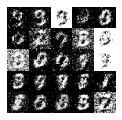

Time for epoch 3 is 22.417644023895264 sec
Epoch: 4/10


Current step 3748: 100%|██████████| 937/937 [00:21<00:00, 43.53it/s, disc_loss=1.39, gen_loss=0.693]


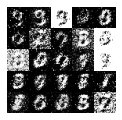

Time for epoch 4 is 22.741964101791382 sec
Epoch: 5/10


Current step 4685: 100%|██████████| 937/937 [00:21<00:00, 43.12it/s, disc_loss=1.39, gen_loss=0.693]


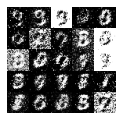

Time for epoch 5 is 22.57454228401184 sec
Epoch: 6/10


Current step 5622: 100%|██████████| 937/937 [00:23<00:00, 40.61it/s, disc_loss=1.39, gen_loss=0.693]


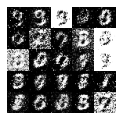

Time for epoch 6 is 23.932769775390625 sec
Epoch: 7/10


Current step 6559: 100%|██████████| 937/937 [00:21<00:00, 42.86it/s, disc_loss=1.39, gen_loss=0.693]


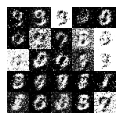

Time for epoch 7 is 23.064756155014038 sec
Epoch: 8/10


Current step 7496: 100%|██████████| 937/937 [00:27<00:00, 33.71it/s, disc_loss=1.39, gen_loss=0.693]


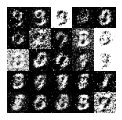

Time for epoch 8 is 29.588183164596558 sec
Epoch: 9/10


Current step 8433: 100%|██████████| 937/937 [00:28<00:00, 33.05it/s, disc_loss=1.39, gen_loss=0.693]


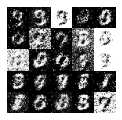

Time for epoch 9 is 29.189623832702637 sec
Epoch: 10/10


Current step 9370: 100%|██████████| 937/937 [00:21<00:00, 43.05it/s, disc_loss=1.39, gen_loss=0.693]


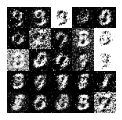

Time for epoch 10 is 22.98561382293701 sec


In [107]:
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

train_iterator = iter(dataset)

for epoch in range(1, EPOCHS + 1):
  start = time.time()
  print('Epoch: {}/{}'.format(epoch, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
 
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if epoch % SAMPLE_INTERVAL == 0:
    sample_images(epoch, save=True, show=True);
  
  print('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

In [108]:
import imageio
import glob

anim_file = SAMPLES_DIR + '/all_images.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(SAMPLES_DIR + '/image_at_epoch_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

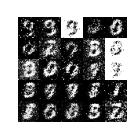

In [109]:
import IPython
from IPython.display import Image
Image(filename=anim_file, embed=True)